# Confirmed Cases per day

In [490]:
%matplotlib inline

In [931]:
from typing import List

In [932]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
import time
import math

In [963]:
__X = json_data['confirmed']['last_updated']
__Y = requests.get(
    "https://coronavirus-tracker-api.herokuapp.com/all"
).json()['confirmed']['last_updated']
print(
    __X
)
print(
    __Y
)
print(
    "Up to date:",
    __X == __Y
)

2020-03-17T23:44:52.584127Z
2020-03-17T23:44:52.584127Z
Up to date: True


In [964]:
try:
    json_data = requests.get("https://coronavirus-tracker-api.herokuapp.com/all").json()
    json.dump(json_data, open(f"coronavirus-tracker-cache-{time.time()}.json", "w"))
except:
    print("Read from cache instead.")

In [965]:
confirmed = pd.DataFrame(json_data['confirmed']['locations'])

In [966]:
states_list = list([
    c for c in
    confirmed[confirmed.country_code == "US"].province.values
    if "," not in c and "Princess" not in c
])

In [967]:
subset_states = states_list

confirmed_subset_states = pd.DataFrame({
    state: pd.Series({
        pd.to_datetime(k): v 
        for k, v in confirmed[confirmed.province == state].history.iloc[0].items()
    }).sort_index() 
    for state in subset_states
})

In [968]:
state_popn = pd.read_csv("StatePopulations.csv")
state_popn = state_popn.set_index("State Name")
state_abbr = pd.read_csv("StateAbbreviations.csv")

In [969]:
doubling_times = get_dataset_doubling_period(confirmed_subset_states[states_list])

dt_and_max_cases = pd.DataFrame([doubling_times]).T.join(
    pd.DataFrame(confirmed_subset_states.max().T, columns=["max"])
)
dt_and_max_cases['Td'] = dt_and_max_cases[0].map(lambda x: x[0])
dt_and_max_cases['b'] = dt_and_max_cases[0].map(lambda x: x[1])
dt_and_max_cases = dt_and_max_cases[['max', 'Td', 'b']]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: RankWarning: Polyfit may be poorly conditioned


`confirmed_subset_states` is a pandas array with a column for each state and a row for each date.

In [970]:
def plot_states(states: List[str] = None, legend: List[str] = False, data_src = None):
    data_src = data_src if data_src else confirmed_subset_states
    states = states if states else data_src.columns
    with plt.style.context("fivethirtyeight"):
        fig_scale = 2
        plt.figure(figsize=(8*fig_scale, 5*fig_scale))
        for state in states:
            in_legend = (legend is True or (isinstance(legend, list) and state in legend))
            state_data = data_src[state]
            state_data = state_data[state_data > 0]
            if in_legend:
                plt.plot(
                    state_data.keys(), 
                    state_data.values, 
                    label=f"{state} — $T_d$ = {np.round(dt_and_max_cases.loc[state].Td, 2)}"
                )
            else:
                plt.plot(
                    state_data.keys(), 
                    state_data.values, 
                    label=None,
                    color="#000000", alpha=0.02
                )
        plt.legend()
        plt.title("Total Confirmed Cases per State")
        plt.ylabel("Confirmed Cases")
        plt.xlabel("Date")
        
        
def plot_states_density(states: List[str] = None, legend: List[str] = False, data_src = None):
    data_src = data_src if data_src else confirmed_subset_states
    states = states if states else data_src.columns
    with plt.style.context("fivethirtyeight"):
        fig_scale = 2
        plt.figure(figsize=(8*fig_scale, 5*fig_scale))
        for state in states:
            try:
                in_legend = (legend is True or (isinstance(legend, list) and state in legend))
                state_data = data_src[state]
                state_data = state_data[state_data > 0]
                if in_legend:
                    plt.plot(
                        state_data.keys(),
                        state_data.values / state_popn.loc[state]['Population'], 
                        label=f"{state} — $T_d$ = {np.round(dt_and_max_cases.loc[state].Td, 2)}"
                    )
                else:
                    plt.plot(
                        state_data.keys(), 
                        state_data.values / state_popn.loc[state]['Population'], 
                        label=None,
                        color="#000000", alpha=0.02
                    )
            except:
                print(f"Failed to render {state}")
        plt.legend()
        plt.axhspan(0.1, 1.0, alpha=0.3)
        plt.axhspan(0.01, 0.1, alpha=0.1)
        plt.text(pd.Timestamp("2020-03-10"), 1.0, "100%")
        plt.text(pd.Timestamp("2020-03-10"), 0.1, "10%")
        plt.text(pd.Timestamp("2020-03-10"), 0.01, "1%")
        plt.title("Confirmed Cases per State (% of State Population)")
        plt.ylabel("Confirmed Cases (% of total state population)")
        plt.yscale("log")
        plt.xlabel("Date")

def plot_developing_doubling_time(states: List[str] = None, data_src=None):
    data_src = data_src if data_src else confirmed_subset_states
    states = states if states else data_src.columns
    with plt.style.context("fivethirtyeight"):
        fig_scale = 2
        plt.figure(figsize=(8*fig_scale, 5*fig_scale))
        for state in states:
            X = pd.to_numeric(
                confirmed_subset_states[[state]].T.keys() - pd.to_datetime("Jan 1 2020")
            )/millis_per_day
            Y = [
                get_dataset_doubling_period(confirmed_subset_states[[state]][:i])[0][0]
                for i in range(len(confirmed_subset_states[[state]]))
            ]
            data = pd.DataFrame({"X": X, "Y": Y})
            data = data[data.Y > 0]
            plt.plot(
                pd.to_datetime("Jan 1 2020") + pd.to_timedelta(data.X, 'days'), data.Y, label=state
            )
        plt.legend()
    plt.title("Estimated $T_d$ of coronavirus over time, per state (low numbers are worse)")
    plt.ylabel("Doubling time (days)")
    plt.xlabel("Date of measurement")
    plt.show()
            
    

millis_per_day = 60*60*24*1000*1000*1000
def get_dataset_doubling_period(dataset, Td_only=False) -> float:
    dataset = dataset[(dataset.T != 0).any()]
    if len(dataset) == 0 or np.Inf in dataset or 0 in dataset:
        return [[0, 0]]
    results = {}
    for i, state in dataset.T.iterrows():
        state = state[state > 0]
        try:
            results[i] = np.polyfit(
                np.log(state.values), 
                (
                    state.T.keys() - pd.to_datetime("Jan 1 2020")
                ).astype(int) / (millis_per_day), 1
            )
        except Exception as e:
            results[i] = np.array([0,0])
    if Td_only:
        return list(results.values())
    return pd.Series(results)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: RankWarning: Polyfit may be poorly conditioned
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:107: RankWarning: Polyfit may be poorly conditioned


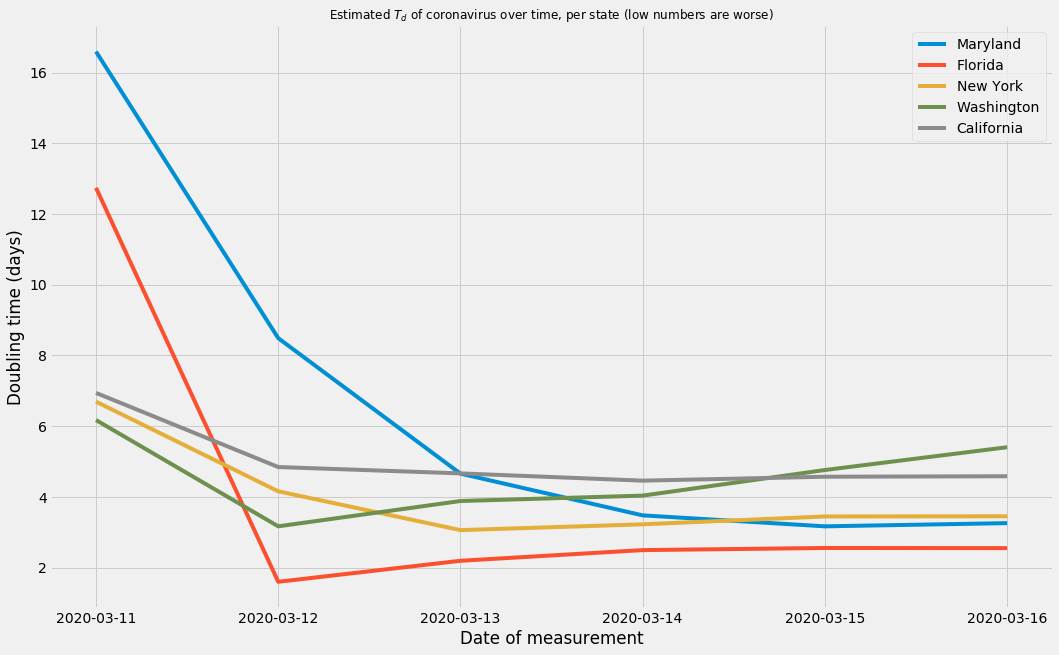

In [971]:
plot_developing_doubling_time(['Maryland', 'Florida', "New York", "Washington", "California"])

Failed to render District of Columbia
Failed to render Puerto Rico
Failed to render Guam
Failed to render Virgin Islands


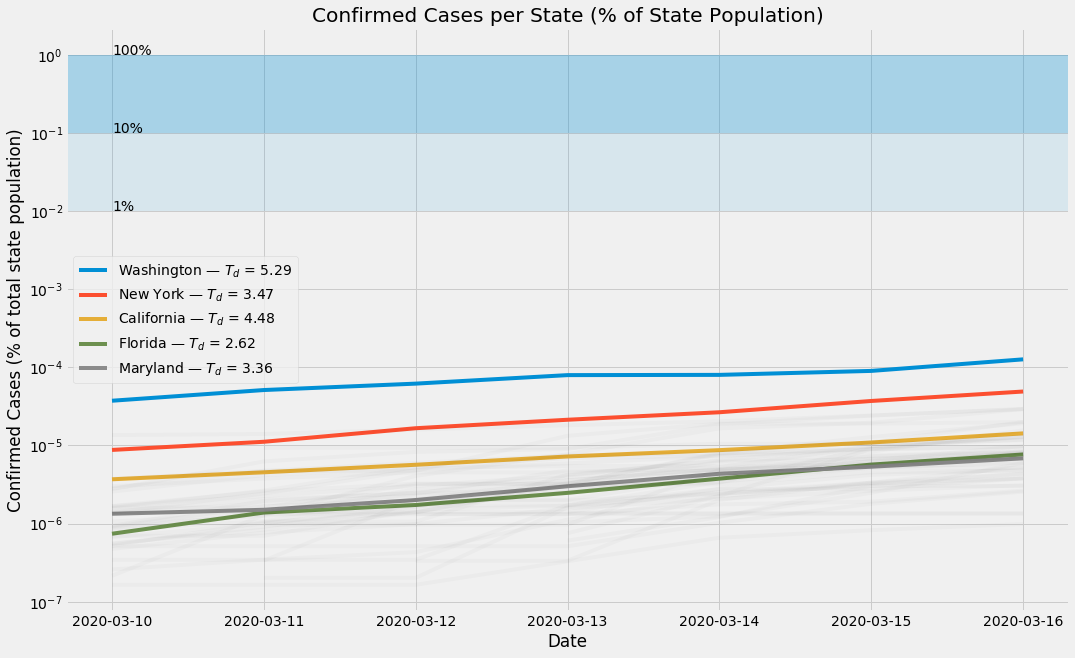

In [972]:
plot_states_density(legend=['Florida', 'New York', 'California', 'Washington', 'Maryland'])

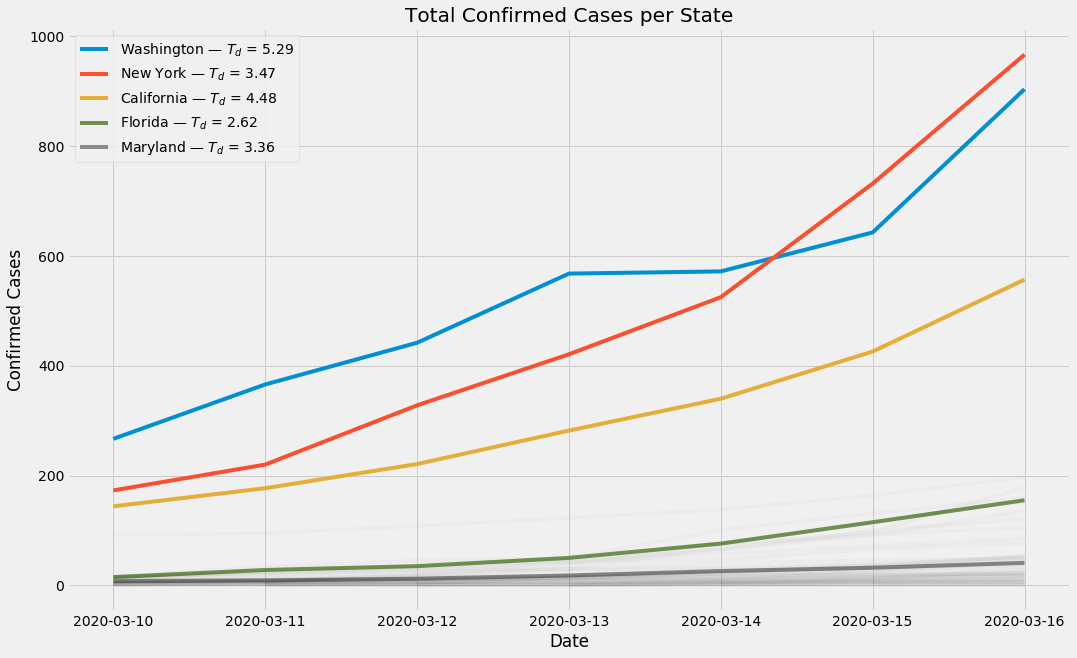

In [973]:
plot_states(legend=['Florida', 'New York', 'California', 'Washington', 'Maryland'])

In [974]:
dt_and_max_cases.describe()

,max,Td,b
count,54.000000,54.000000,54.000000
mean,84.537037,3.613768,57.810361
std,188.642590,4.973096,18.897056
min,0.000000,0.000000,0.000000
25%,10.250000,1.823870,60.328999
50%,24.000000,2.655201,63.635223
75%,52.750000,3.462943,68.523050
max,967.000000,33.906411,71.969184


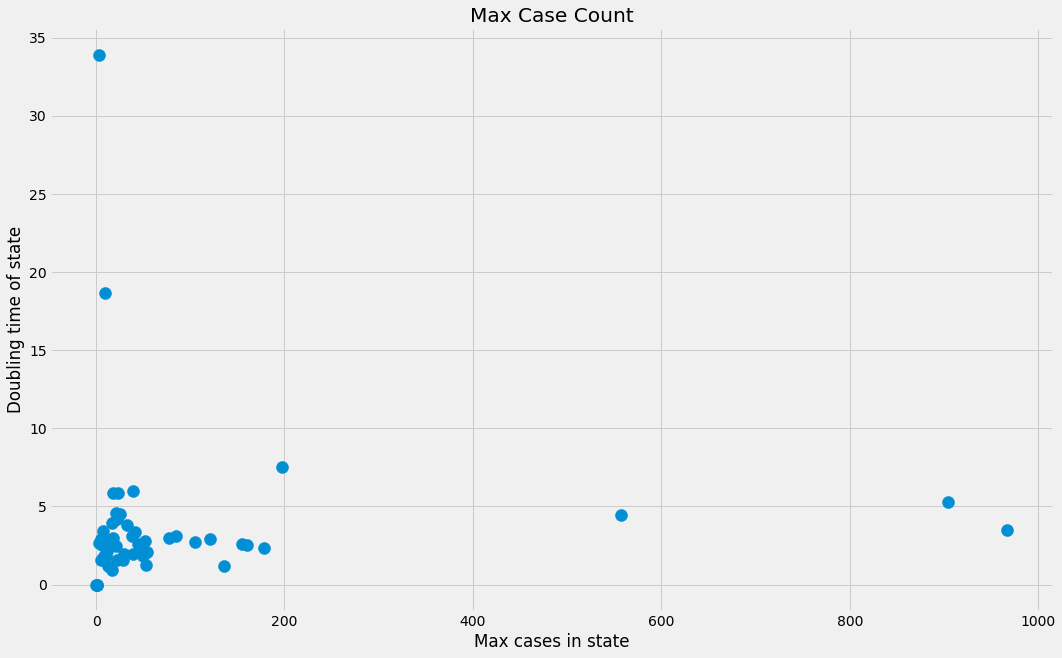

In [975]:
with plt.style.context("fivethirtyeight"):
    fig_scale = 2
    plt.figure(figsize=(8*fig_scale, 5*fig_scale))
    plt.title("Max Case Count")
    plt.xlabel("Max cases in state")
    plt.ylabel("Doubling time of state")
    plt.scatter(dt_and_max_cases['max'], dt_and_max_cases.Td, s=144)

# To learn about another country:

In [953]:
countries = [('italy', 'IT'), ('india', 'IN'), ('israel', 'IS'), ('china', 'CN'), ('southkorea', 'SK')]

countries = pd.DataFrame({
    country: pd.Series({
        pd.to_datetime(k): v 
        for k, v in confirmed[confirmed.country_code == abbr].iloc[0]['history'].items()
    }).sort_index()
for country, abbr in countries})

In [961]:
get_dataset_doubling_period(countries[['italy']])

italy    [3.4825331227812746, 36.410053494929706]
dtype: object

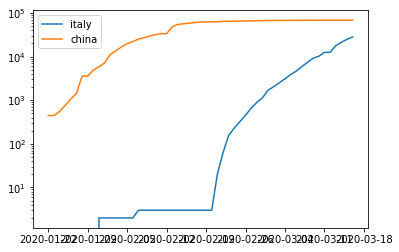

In [977]:
plt.plot(countries[['italy']], label='italy')
plt.plot(countries[['china']], label='china')
plt.yscale("log")
plt.legend()